# Entrainement sur les appartements de l'Essonne en 2022

Ce notebook permet de trouver un modèle pour estimer le prix au mètre carré d'un appartement en Essonne d'après les ventes de 2022

In [1]:
import pandas as pd
import gzip
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

## I- Introduction

Chargement du dataframe trié dans le notebook *Etude des évolution des prix dans le 91* 

In [2]:
df_appartements = pd.read_csv(r"../data/df_appartements_2022_91.csv")
df_appartements.head()

,date_mutation,nb_elements,valeur_fonciere,code_commune,nom_commune,surface_reelle_bati,somme_terrain,local_dependance,local_terrain,nombre_pieces_principales,l_code_nature_culture,l_code_nature_culture_speciale,longitude,latitude,prix_m_carre,prix_mcarr_moy_ville
0,2022-09-20,2,137000.0,91016,Angerville,85.0,0.0,1,0,3.0,{'PDC'},{'PDCS'},1.999966,48.314096,1611.764706,1923.344948
1,2022-02-10,1,81000.0,91016,Angerville,35.0,0.0,0,0,2.0,{'PDC'},{'PDCS'},1.998827,48.310925,2314.285714,1923.344948
2,2022-10-27,2,150000.0,91016,Angerville,80.0,0.0,1,0,3.0,{'PDC'},{'PDCS'},1.991374,48.317805,1875.000000,1923.344948
3,2022-05-10,2,52000.0,91016,Angerville,35.0,61.0,0,1,3.0,{'S'},{'PDCS'},1.998949,48.311124,1485.714286,1923.344948
4,2022-09-16,2,132000.0,91016,Angerville,52.0,0.0,1,0,2.0,{'PDC'},{'PDCS'},1.999966,48.314096,2538.461538,1923.344948


Affichage des paramètres statistiques des différentes variables du dataframe

In [3]:
df_appartements.describe()

,nb_elements,valeur_fonciere,code_commune,surface_reelle_bati,somme_terrain,local_dependance,local_terrain,nombre_pieces_principales,longitude,latitude,prix_m_carre,prix_mcarr_moy_ville
count,8481.000000,8481.000000,8481.000000,8481.000000,8481.000000,8481.000000,8481.000000,8481.000000,8481.000000,8481.000000,8481.000000,8481.000000
mean,2.506898,182605.411987,91358.217899,58.727155,1.546516,1.501002,0.005896,2.812640,2.342496,48.651963,3261.649646,3112.646293
std,0.871039,73334.082301,200.360246,21.017066,29.898831,0.867538,0.086674,1.099061,0.113391,0.071427,1080.119398,630.913084
min,1.000000,1.000000,91016.000000,6.000000,0.000000,0.000000,0.000000,0.000000,1.958322,48.310925,0.016393,1546.391753
25%,2.000000,134000.000000,91191.000000,43.000000,0.000000,1.000000,0.000000,2.000000,2.264141,48.614963,2495.726496,2535.792165
50%,2.000000,170000.000000,91345.000000,60.000000,0.000000,1.000000,0.000000,3.000000,2.348890,48.672407,3147.945205,3089.123379
75%,3.000000,219450.000000,91534.000000,72.000000,0.000000,2.000000,0.000000,4.000000,2.435287,48.702604,3854.838710,3519.656908
max,21.000000,790000.000000,91692.000000,318.000000,1808.000000,20.000000,2.000000,8.000000,2.565588,48.761216,22033.333333,5706.896552


Affichage grace à un diagramme circulaire du nombre de dépendances par mutation.

On en déduira par la suite, que le nombre de dépendances n'aura pas de poids dans l'estamtion du prix du bien car elles peuvent désigner une cave, une place de parking, un balcon, ... Mais il n'y a pas plus de précision dans le dataframe.

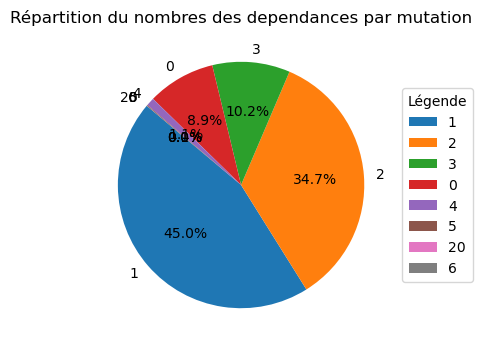

In [4]:
value_counts = df_appartements['local_dependance'].value_counts()

# Créez un diagramme circulaire
plt.figure(figsize=(4, 4))  
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)

# Ajoutez un titre
plt.title("Répartition du nombres des dependances par mutation")
plt.legend(title="Légende", loc="center left", bbox_to_anchor=(1, 0.5))
# Affichez le diagramme
plt.show()

Graphique du prix du bien en fonction du nombre de dépendances

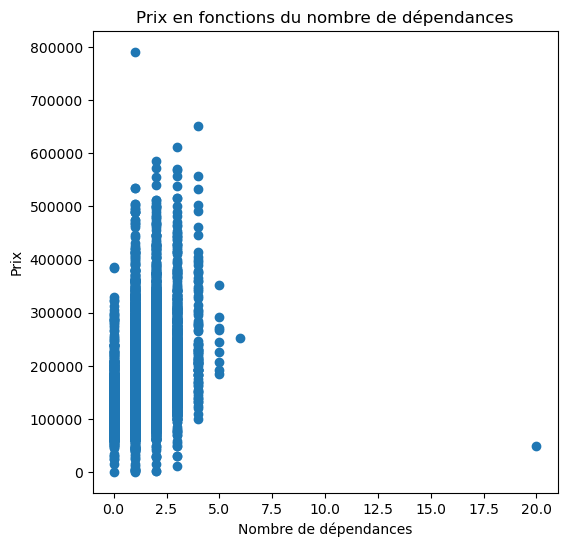

In [5]:
plt.figure(figsize=(6, 6))
# Créer le nuage de points
plt.scatter(x = df_appartements['local_dependance'],
            y = df_appartements['valeur_fonciere'])

# Personnaliser le graphe
plt.title("Prix en fonctions du nombre de dépendances")
plt.xlabel('Nombre de dépendances')
plt.ylabel('Prix')

# Afficher le graphe
plt.show()

En observant ce graphique, on voit que le prix ne dépend pas du nombre de dépendances.


---

## II- Réduction des données

Nous allons maintenant gérer les valeurs abérantes, en effet certains appartements ont un prix dérisoire ou très élevé, ainsi qu'une surface ou un nombre de pièces qui pourrait faire perdre de la précision à notre modèle. 

Pour cela, nous allons utiliser un z-score pour réduire le nombre de lignes de notre dataframe. On peut visualiser cette réduction par les boîtes à moustaches suivantes.

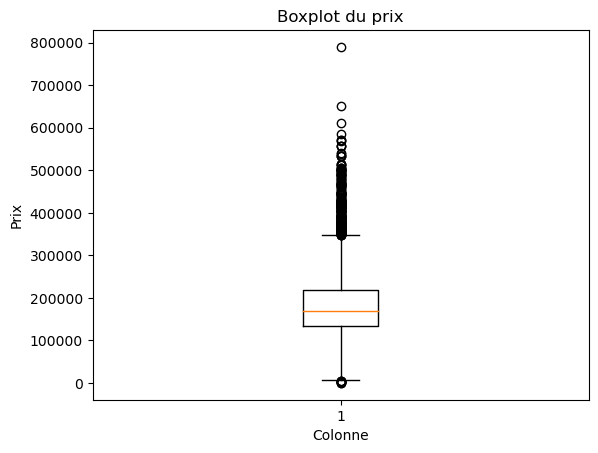

In [6]:
plt.boxplot([df_appartements['valeur_fonciere']])

# Ajouter un titre et des labels d'axe
plt.title('Boxplot du prix')
plt.xlabel('Colonne')
plt.ylabel('Prix')

# Afficher le graphique
plt.show()

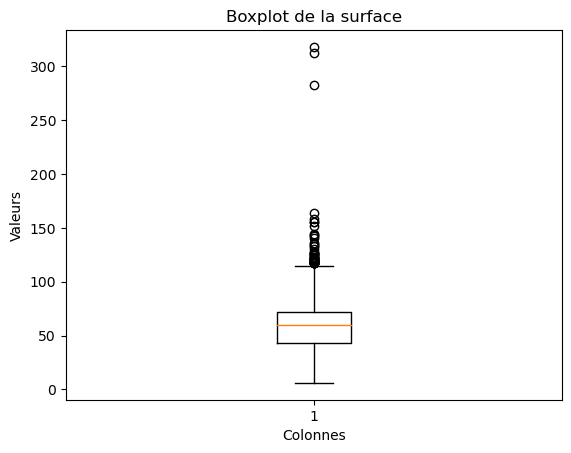

In [7]:
plt.boxplot([df_appartements['surface_reelle_bati']])

# Ajouter un titre et des labels d'axe
plt.title('Boxplot de la surface')
plt.xlabel('Colonnes')
plt.ylabel('Valeurs')

# Afficher le graphique
plt.show()

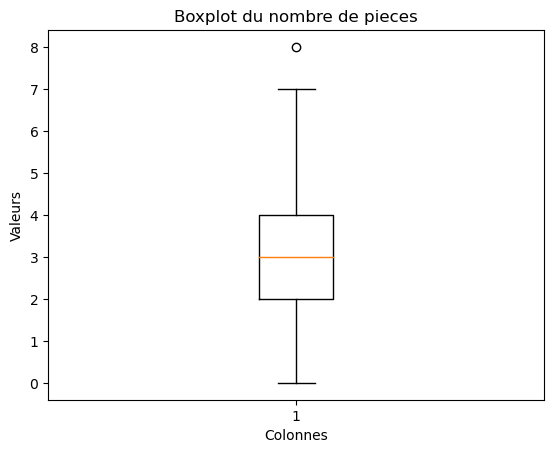

In [8]:
plt.boxplot([df_appartements['nombre_pieces_principales']])

# Ajouter un titre et des labels d'axe
plt.title('Boxplot du nombre de pieces')
plt.xlabel('Colonnes')
plt.ylabel('Valeurs')

# Afficher le graphique
plt.show()

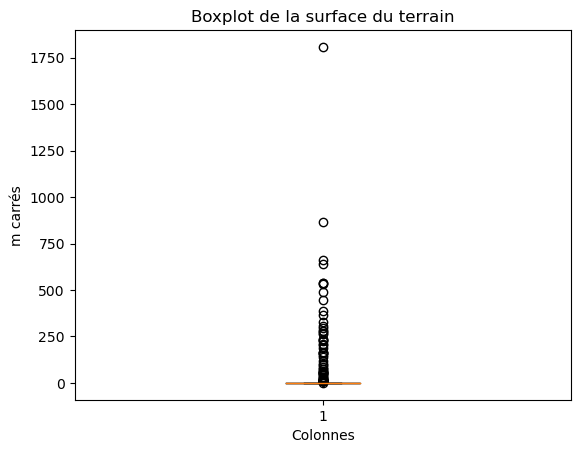

In [9]:
plt.boxplot([df_appartements['somme_terrain']])

# Ajouter un titre et des labels d'axe
plt.title('Boxplot de la surface du terrain')
plt.xlabel('Colonnes')
plt.ylabel('m carrés')

# Afficher le graphique
plt.show()

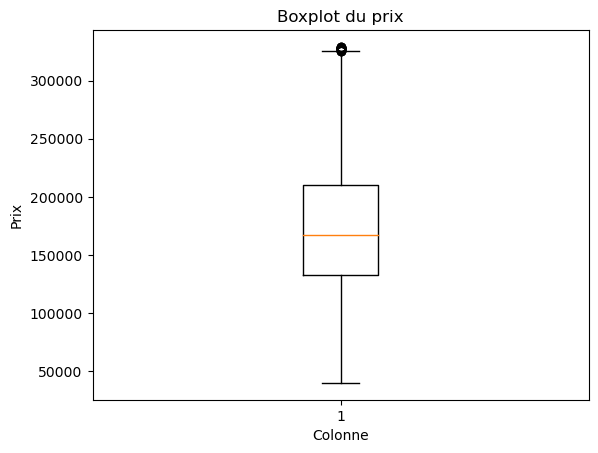

,nb_elements,valeur_fonciere,code_commune,surface_reelle_bati,somme_terrain,local_dependance,local_terrain,nombre_pieces_principales,longitude,latitude,prix_m_carre,prix_mcarr_moy_ville
count,8091.000000,8091.000000,8091.000000,8091.000000,8091.000000,8091.000000,8091.000000,8091.000000,8091.000000,8091.000000,8091.000000,8091.000000
mean,2.486343,173775.582352,91355.382277,57.366704,1.465703,1.480534,0.005809,2.758250,2.345071,48.649453,3213.991199,3075.550582
std,0.862861,57201.376238,201.732602,19.705850,29.702408,0.859448,0.086640,1.076501,0.113304,0.071499,1042.370470,612.708410
min,1.000000,40000.000000,91016.000000,6.000000,0.000000,0.000000,0.000000,0.000000,1.958322,48.310925,470.588235,1546.391753
25%,2.000000,133000.000000,91179.000000,42.000000,0.000000,1.000000,0.000000,2.000000,2.267934,48.613350,2474.788136,2535.792165
50%,2.000000,167050.000000,91345.000000,59.000000,0.000000,1.000000,0.000000,3.000000,2.351890,48.668911,3105.263158,3045.556887
75%,3.000000,210009.500000,91540.000000,70.000000,0.000000,2.000000,0.000000,3.000000,2.437470,48.701222,3782.608696,3399.295299
max,21.000000,329000.000000,91692.000000,283.000000,1808.000000,20.000000,2.000000,8.000000,2.565588,48.761216,22033.333333,5706.896552


In [10]:
from scipy import stats

# Calculez les Z-scores pour une colonne spécifique
z_scores = np.abs(stats.zscore(df_appartements['valeur_fonciere']))

seuil = 2

df_appartements = df_appartements[(z_scores < seuil)]

plt.boxplot([df_appartements['valeur_fonciere']])

# Ajouter un titre et des labels d'axe
plt.title('Boxplot du prix')
plt.xlabel('Colonne')
plt.ylabel('Prix')

# Afficher le graphique
plt.show()

#Nouvelle description du dataframe après réduction avec le Z-score.
df_appartements.describe()

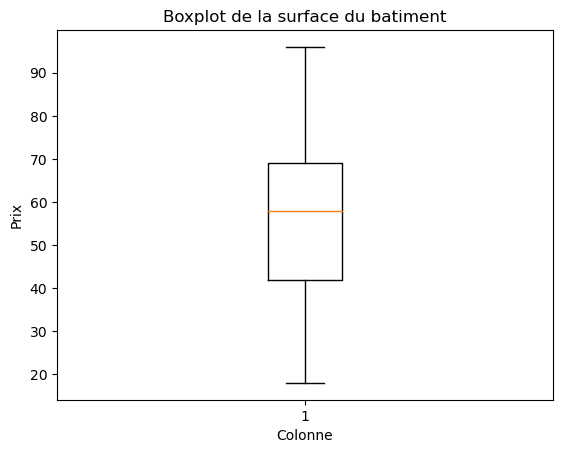

In [11]:
z_scores = np.abs(stats.zscore(df_appartements['surface_reelle_bati']))

seuil = 2

df_appartements = df_appartements[(z_scores < seuil)]

plt.boxplot([df_appartements['surface_reelle_bati']])

# Ajouter un titre et des labels d'axe
plt.title('Boxplot de la surface du batiment')
plt.xlabel('Colonne')
plt.ylabel('Prix')

# Afficher le graphique
plt.show()

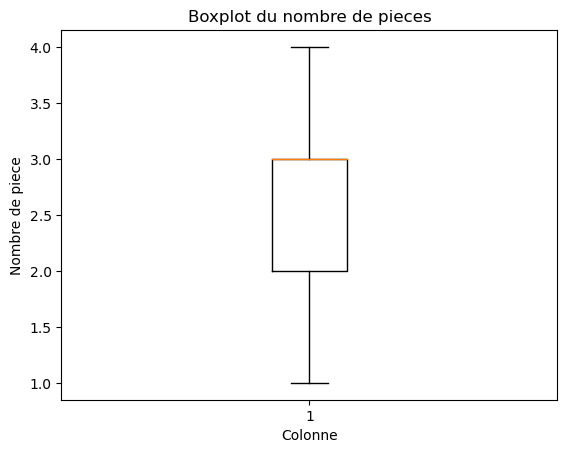

In [12]:
z_scores = np.abs(stats.zscore(df_appartements['nombre_pieces_principales']))

seuil = 2

df_appartements = df_appartements[(z_scores < seuil)]

plt.boxplot([df_appartements['nombre_pieces_principales']])

# Ajouter un titre et des labels d'axe
plt.title('Boxplot du nombre de pieces')
plt.xlabel('Colonne')
plt.ylabel('Nombre de piece')

# Afficher le graphique
plt.show()

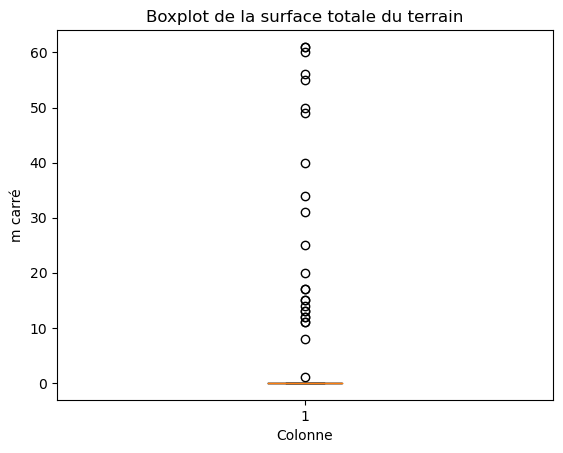

In [13]:
z_scores = np.abs(stats.zscore(df_appartements['somme_terrain']))

seuil = 2

df_appartements = df_appartements[(z_scores < seuil)]

plt.boxplot([df_appartements['somme_terrain']])

# Ajouter un titre et des labels d'axe
plt.title('Boxplot de la surface totale du terrain')
plt.xlabel('Colonne')
plt.ylabel('m carré')

# Afficher le graphique
plt.show()

Comme la plupart des appartements n'ont pas de terrain, notre boite à moustache est ecrasée en 0.

In [14]:
df_appartements.shape

(7574, 16)

On a donc, après traitement des données, 7574 appartements vendus dans le 91

---

Création de la colonne prix au m² moyen par ville

Affichage par ville du prix moyen au m² par ordre décroissant

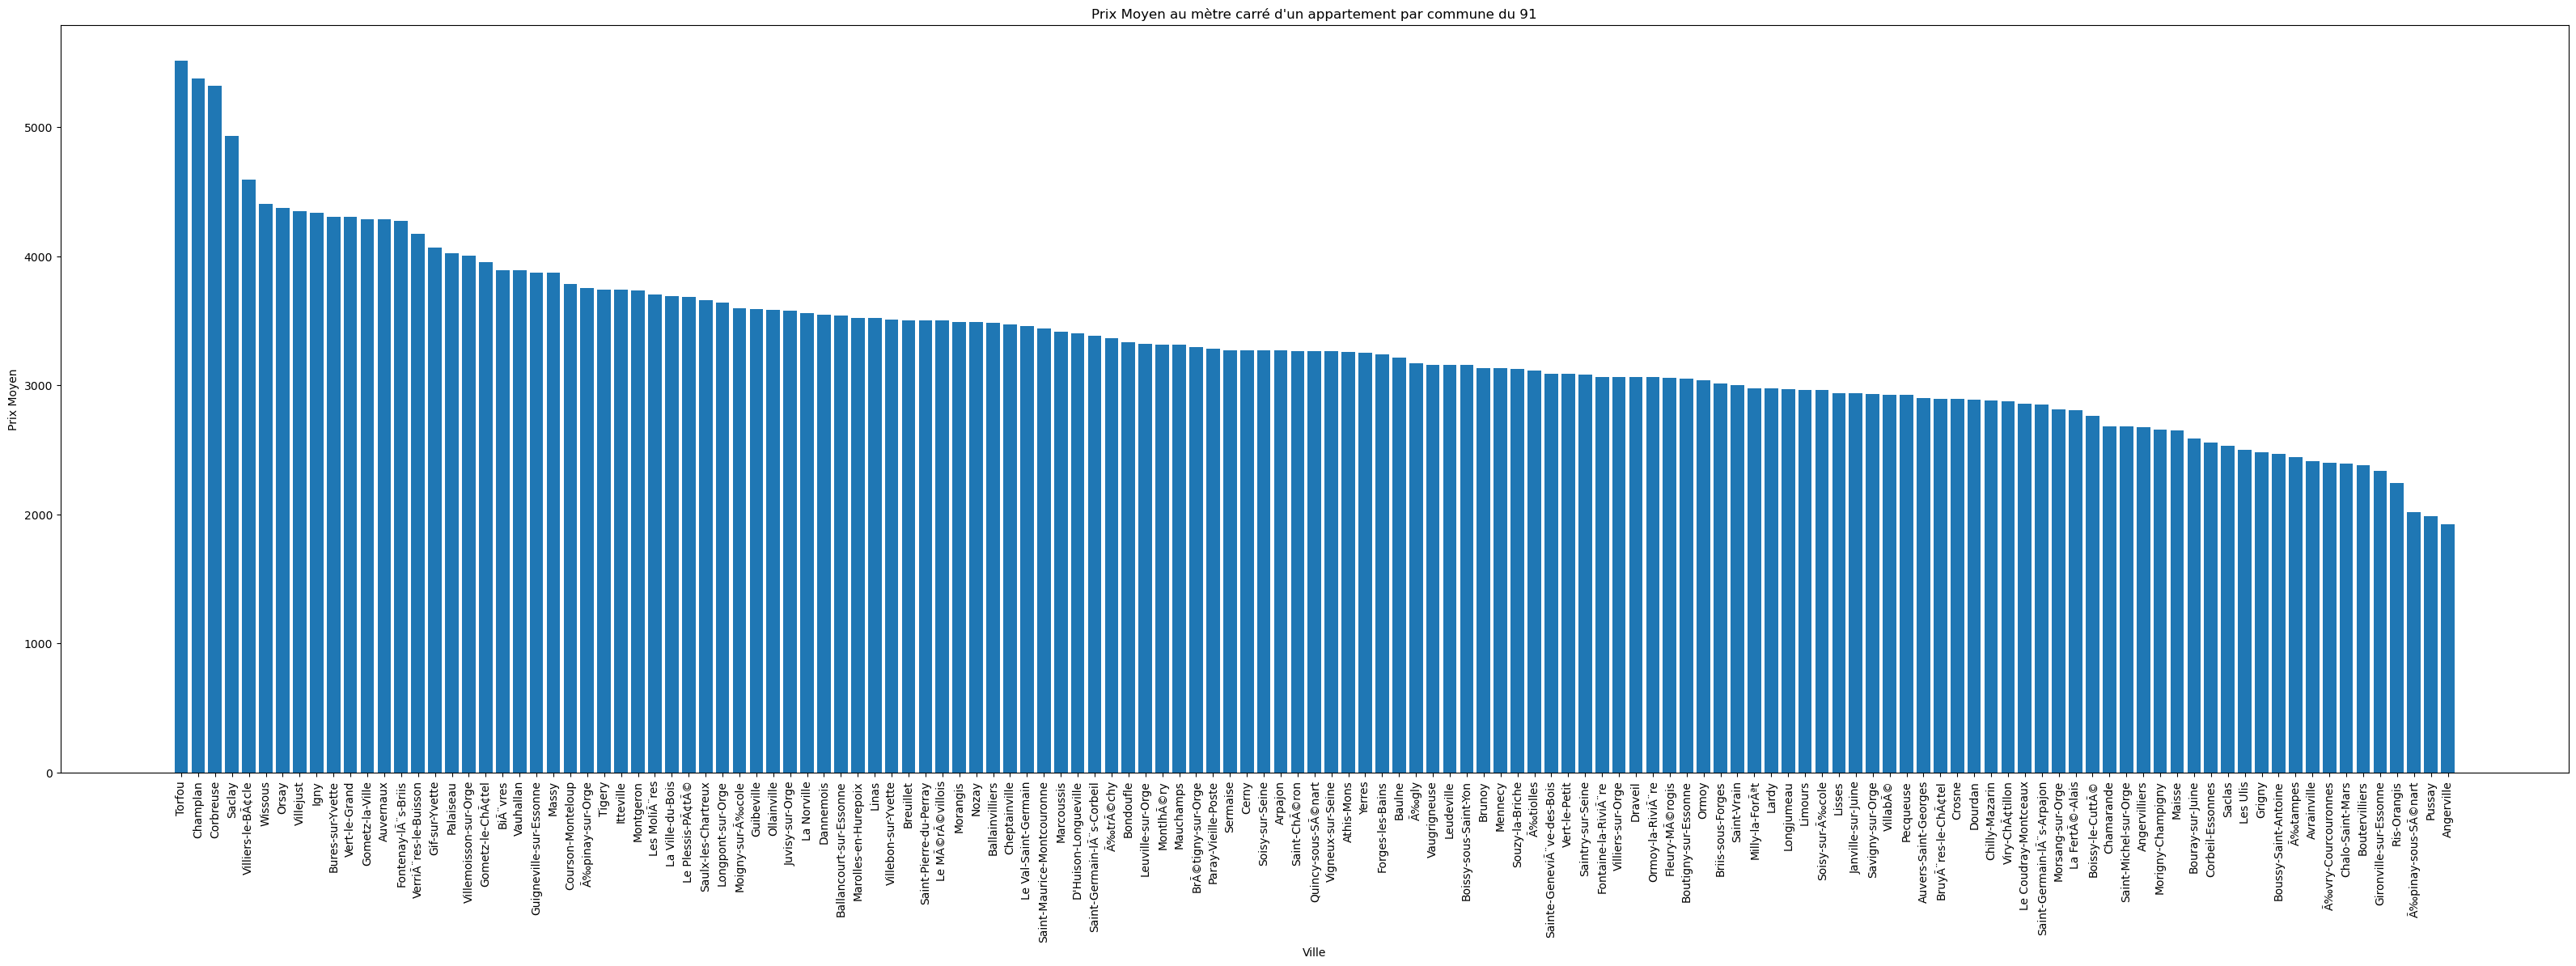

In [15]:
prix_ville = df_appartements.groupby('code_commune')['valeur_fonciere'].sum()
mcarre_ville = df_appartements.groupby('code_commune')['surface_reelle_bati'].sum()
ville = df_appartements['nom_commune'].unique()

prix_mcarr_ville = pd.DataFrame({'nom_commune': ville, 
                                 'prix_ville': prix_ville.values,
                                 'surface_ville' : mcarre_ville.values
                                })

prix_mcarr_ville['prix_mcarr_moy_ville'] = prix_mcarr_ville['prix_ville']/prix_mcarr_ville['surface_ville']

prix_mcarr_ville =  prix_mcarr_ville.drop(['prix_ville', 'surface_ville'], axis = 1)

prix_mcarr_ville = prix_mcarr_ville.sort_values(by='prix_mcarr_moy_ville', ascending=False)

plt.figure(figsize=(40, 12))
# Créer le graphe en barres
plt.bar(x = prix_mcarr_ville['nom_commune'],
        height = prix_mcarr_ville['prix_mcarr_moy_ville'])

# Personnaliser le graphe
plt.xticks(rotation=90)
plt.title("Prix Moyen au mètre carré d'un appartement par commune du 91")
plt.xlabel('Ville')
plt.ylabel('Prix Moyen')

# Afficher le graphe
plt.show()

Corrélations entre les différentes variables

Ajout de la colonne prix au mêtre carré par appartement

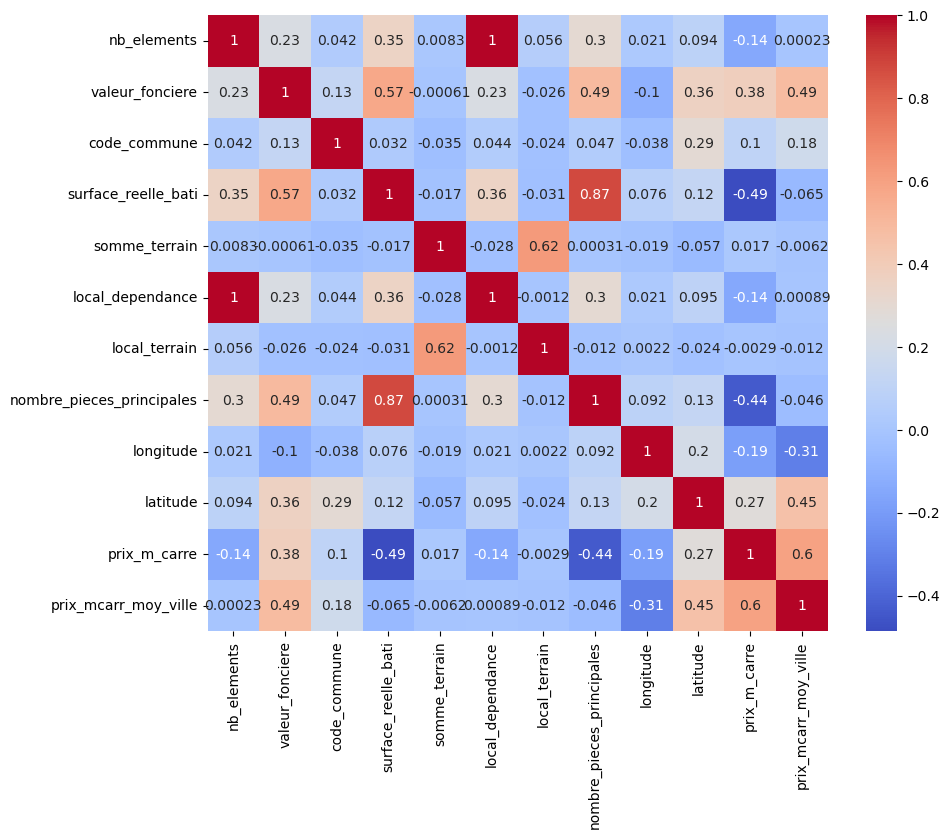

In [16]:
fig, ax = plt.subplots(figsize=(10,8))
mat = df_appartements.corr()
sns.heatmap(mat, annot=True, cmap ="coolwarm");

Corrélation qui n'est pas forte mais plus élevée entre prix_m_carre et la surface, le nombre de pièces, le code commune et somme_terrain

In [17]:
df_appartements.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7574 entries, 0 to 8479
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   date_mutation                   7574 non-null   object 
 1   nb_elements                     7574 non-null   int64  
 2   valeur_fonciere                 7574 non-null   float64
 3   code_commune                    7574 non-null   int64  
 4   nom_commune                     7574 non-null   object 
 5   surface_reelle_bati             7574 non-null   float64
 6   somme_terrain                   7574 non-null   float64
 7   local_dependance                7574 non-null   int64  
 8   local_terrain                   7574 non-null   int64  
 9   nombre_pieces_principales       7574 non-null   float64
 10  l_code_nature_culture           7574 non-null   object 
 11  l_code_nature_culture_speciale  7574 non-null   object 
 12  longitude                       75

Enregistrement du nouveau dataframe

In [18]:
nom_fichier = r'../data/df_appartements_trait_2022_91.csv'
df_appartements.to_csv(nom_fichier, index=False)

## II- Entrainement des modèles

### 1er modèle : Moyenne

In [19]:
from sklearn.model_selection import cross_validate, cross_val_predict 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, f1_score
from sklearn.model_selection import train_test_split

In [20]:
data = df_appartements[['surface_reelle_bati', 'nombre_pieces_principales', 'somme_terrain', 'code_commune', 'prix_mcarr_moy_ville']]
target = df_appartements['prix_m_carre']

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=101)

mean_value = np.mean(y_train)

predictions = np.full_like(y_test, fill_value=mean_value)

from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

percentage_errors = (y_test - predictions) / y_test
mape = np.mean(np.abs(percentage_errors)) * 100  



print(f"MSE: {mse}")
print(f"RMSE: {np.sqrt(mse)}")
print(f"MAE: {mae}")
print(f"R2: {r2}")
print(f"MAPE: {mape}%")


MSE: 944343.6113196533
RMSE: 971.7734362080769
MAE: 767.2912512962728
R2: -0.0003731157422766085
MAPE: 26.999501001610497%


Issu de ce premier modèle, on obtient trois métriques
* l' Erreur Quadratique Moyenne, attention cependant à l'unité du modèle
* la Racine Carrée de l' Erreur Quadratique Moyenne, peut-être plus adaptée
* l'Erreur Moyenne Absolue
* le R² 
* la MAPE, l'Erreur Moyenne Absolue en Pourcentage qui sera la plus utile à étudier car l'étendue des prix au mètre carré est élevée

Le but de ce premier modèle est de s'en servir comme base, et voir si les modèles suivant son capable de générer une MAPE plus basse.

### 2ème modèle : Regression Linéaire

In [21]:
from sklearn.linear_model import LinearRegression

In [22]:
model_1 = LinearRegression()
model_1.fit(X_train, y_train)

LinearRegression()

In [23]:
pred = model_1.predict(X_train)
pred_test = model_1.predict(X_test)


mse = mean_squared_error(y_train, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train, pred)
r2 = r2_score(y_train, pred)

mse_test = mean_squared_error(y_test, pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, pred_test)
r2_test = r2_score(y_test, pred_test)
percentage_errors = (y_test - pred_test) / y_test
mape = np.mean(np.abs(percentage_errors)) * 100  

# Affichez les métriques
print(f"MSE train: {mse}")
print(f"MSE test: {mse_test}")
print(f"RMSE train: {rmse}")
print(f"RMSE test: {rmse_test}")
print(f"MAE train: {mae}")
print(f"MAE test: {mae_test}")
print(f"R-squared train: {r2}")
print(f"R-squared test: {r2_test}")
print(f"MAPE: {mape}%")



MSE train: 426245.3820339054
MSE test: 413063.8456092378
RMSE train: 652.8747062292316
RMSE test: 642.7004322460331
MAE train: 491.93691431652036
MAE test: 491.3284650643326
R-squared train: 0.5563005151189346
R-squared test: 0.562428377468285
MAPE: 16.67612793654181%


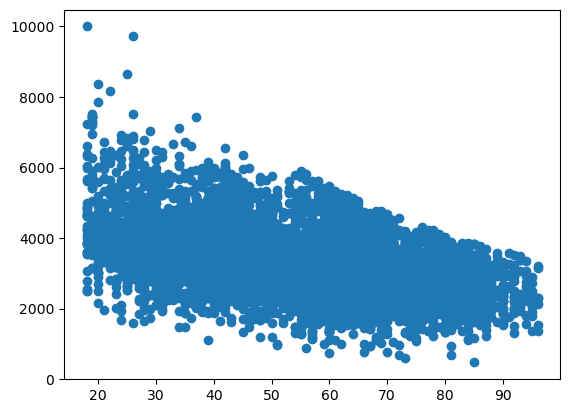

In [24]:
plt.scatter(x = df_appartements['surface_reelle_bati'], y =df_appartements['prix_m_carre'])

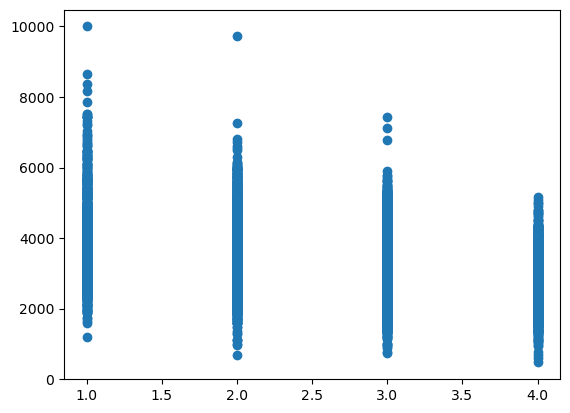

In [25]:
plt.scatter(x = df_appartements['nombre_pieces_principales'], y =df_appartements['prix_m_carre'])

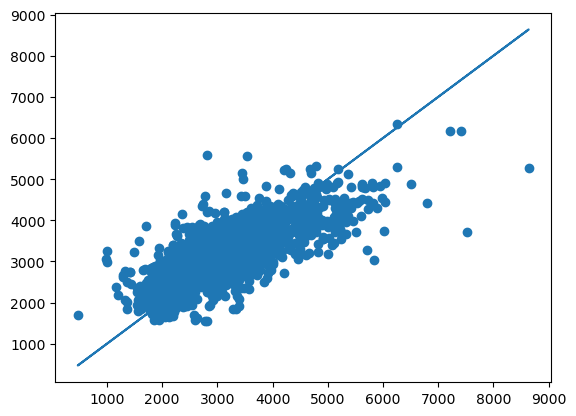

In [26]:
pred_test = model_1.predict(X_test)

plt.scatter(y_test, pred_test)
plt.plot(y_test,y_test)

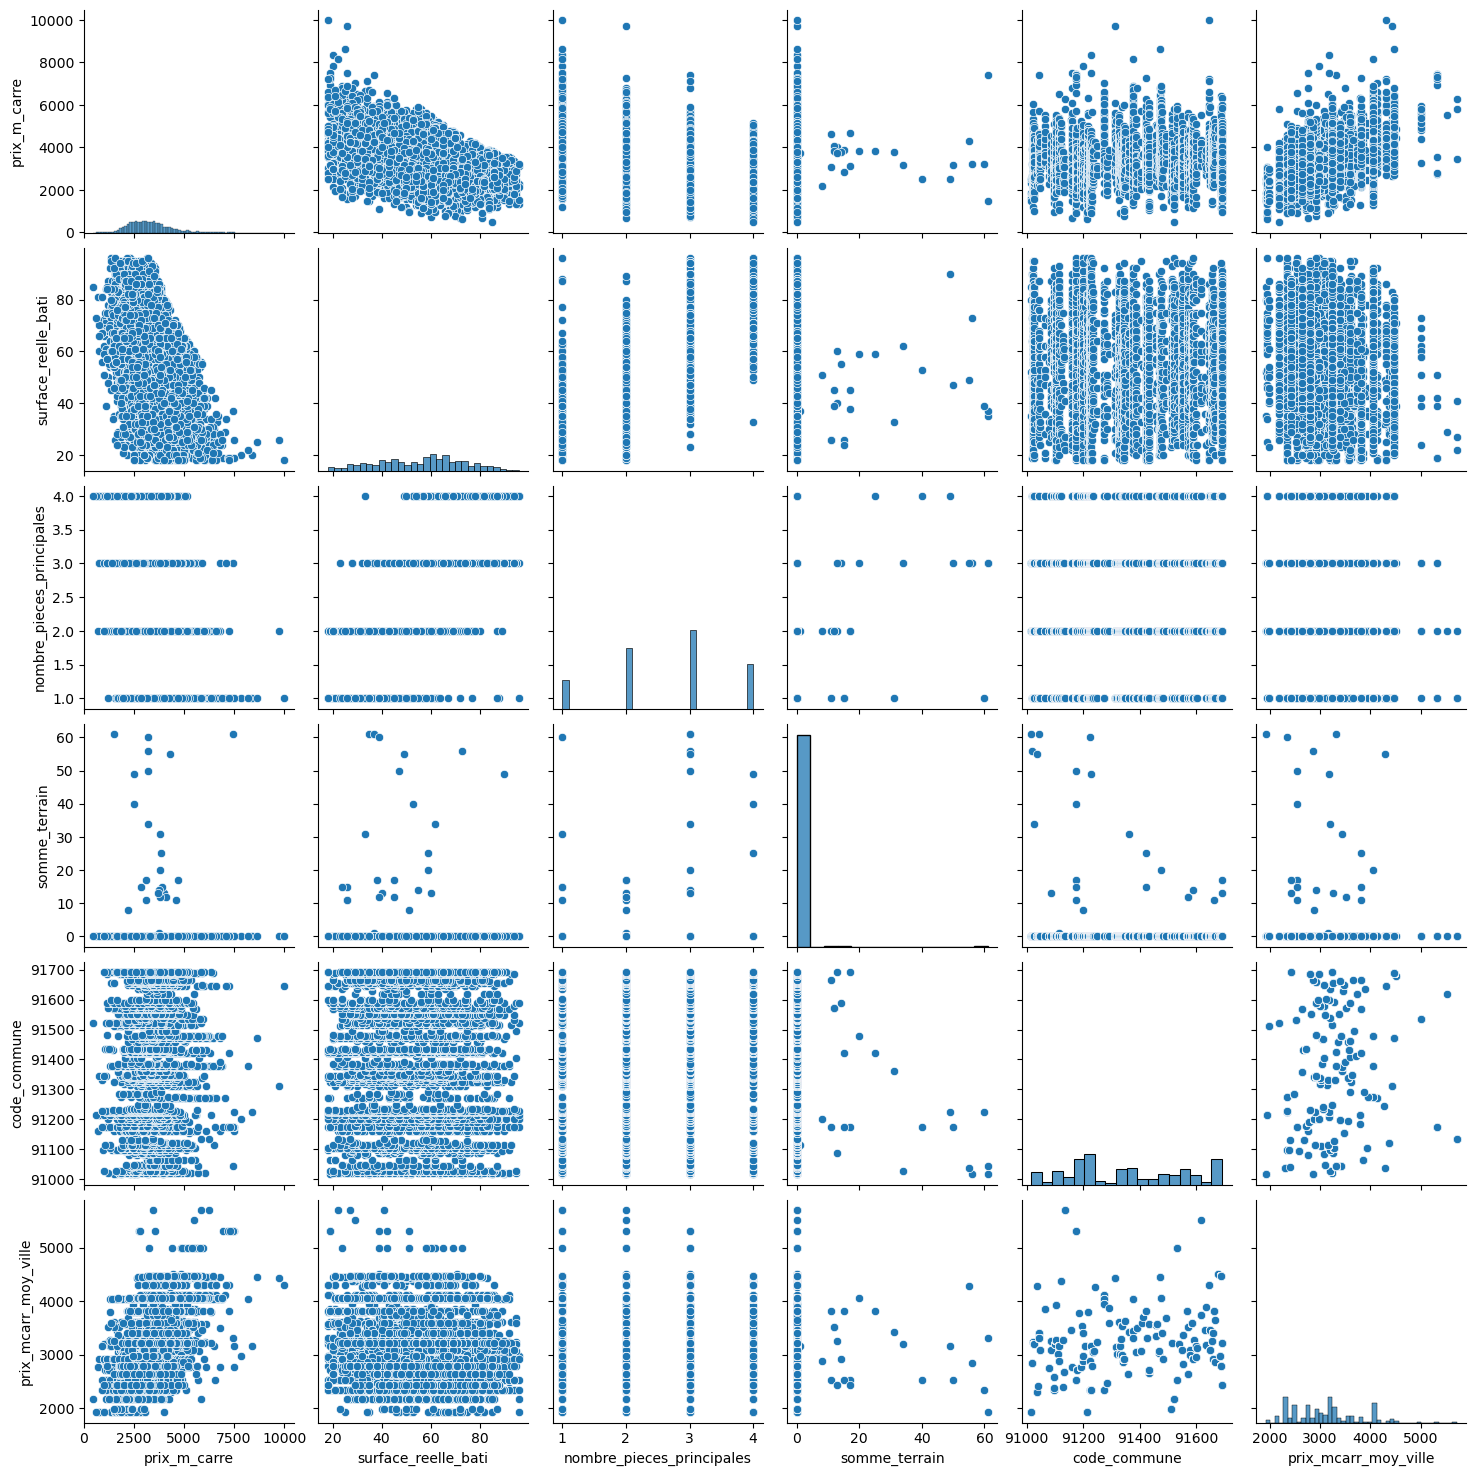

In [27]:
sns.pairplot(df_appartements[['prix_m_carre', 'surface_reelle_bati', 'nombre_pieces_principales', 'somme_terrain', 'code_commune', 'prix_mcarr_moy_ville']]);

Ces graphiques sont utiles pour montrer qu'on n'a pas un modèle linéaire, il faut donc partir sur une régression non linéaire.

### 3eme modele: Non linéaire
#### Random Forest


In [28]:
from sklearn.ensemble import RandomForestRegressor

In [29]:
model = RandomForestRegressor(n_estimators=100, random_state=42)  # Exemple d'hyperparamètres
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [30]:
y_pred = model.predict(X_test)

In [31]:
percentage_errors = (y_test - y_pred) / y_test
mape = np.mean(np.abs(percentage_errors)) * 100  
print(f"MAPE: {mape}%")

MAPE: 15.404751959706681%


In [32]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")

MSE: 385533.99982800597
RMSE: 620.9138425160177
R-squared: 0.5915916155841123


Après une étude sans optimiser les hyper-paramètres, cherchons maintenant à les optimiser grâce à GridSearchCV

In [33]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Meilleurs paramètres trouvés par Grid Search:", best_params)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

percentage_errors = (y_test - y_pred) / y_test
mape = np.mean(np.abs(percentage_errors)) * 100  
print(f"MAPE: {mape}%")

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")

Meilleurs paramètres trouvés par Grid Search: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
MAPE: 14.918181886613887%
MSE: 338651.83496870985
RMSE: 581.9379992479523
R-squared: 0.6412553786157679


### Grandient Boosting Regressor

In [34]:
from sklearn.ensemble import GradientBoostingRegressor

In [35]:
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)  # Exemple d'hyperparamètres
model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [36]:
y_pred = model.predict(X_test)

In [37]:
percentage_errors = (y_test - y_pred) / y_test
mape = np.mean(np.abs(percentage_errors)) * 100  
print(f"MAPE: {mape}%")

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)


print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")

MAPE: 15.59923146474218%
MSE: 356209.6161407387
RMSE: 596.8329884823213
R-squared: 0.6226558645765521


De même, cherchons à optimiser les hyper-paramètres.

In [38]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Créez une instance du modèle GradientBoostingRegressor
model = GradientBoostingRegressor(random_state=42)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Meilleurs paramètres trouvés par Grid Search:", best_params)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)


percentage_errors = (y_test - y_pred) / y_test
mape = np.mean(np.abs(percentage_errors)) * 100  
print(f"MAPE: {mape}%")

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)


print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")

Meilleurs paramètres trouvés par Grid Search: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
MAPE: 15.301704761185567%
MSE: 347599.20555189863
RMSE: 589.575445173812
R-squared: 0.6317771453956613


## Conclusion:

Ici, notre meilleur modèle, avec une MAPE de 14.92%, est le Random Forest Regressor avec les paramètres suivants 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100